# Compuates distances between municipalities and epicenters

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import folium
import geopandas as gpd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import math
import folium
import datetime
from os import listdir
from os.path import isfile, join

from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
import matplotlib 
import matplotlib.pyplot as plt

font = {'size'   : 16}

matplotlib.rc('font', **font)

In [46]:
mymap = gpd.read_file('quake_data/Comuni2016/Com01012016_WGS84.shp',encoding='utf-8').to_crs('epsg:4326')
mymap = mymap[['COD_REG','COMUNE','geometry']]
mymap.columns = ['COD_REG','Comune','geometry']
map_reg = gpd.read_file('quake_data/Reg/Reg01012016_WGS84.shp').to_crs('epsg:4326')
map_reg = map_reg[map_reg['DEN_REG'].isin(['Marche','Lazio','Abruzzo','Umbria'])]
map_reg = map_reg[['COD_REG','DEN_REG','geometry']]
map_reg.columns = ['COD_REG','Regione','geometry']
map_reg

,COD_REG,Regione,geometry
9,10,Umbria,"MULTIPOLYGON (((12.35804 43.61649, 12.35857 43..."
10,11,Marche,"POLYGON ((12.75621 43.96864, 12.75644 43.96851..."
11,12,Lazio,"MULTIPOLYGON (((12.24362 41.73787, 12.24419 41..."
12,13,Abruzzo,"MULTIPOLYGON (((14.23309 42.46541, 14.23313 42..."


In [47]:
mapx = mymap.merge(map_reg[['COD_REG','Regione']])
mapx

,COD_REG,Comune,geometry,Regione
0,11,Ripatransone,"POLYGON ((13.79857 43.03372, 13.79856 43.03366...",Marche
1,11,Trecastelli,"POLYGON ((13.11299 43.72705, 13.11340 43.72703...",Marche
2,11,Massa Fermana,"POLYGON ((13.47962 43.16622, 13.47990 43.16615...",Marche
3,11,Monsampietro Morico,"POLYGON ((13.56050 43.08014, 13.56080 43.07984...",Marche
4,11,Servigliano,"POLYGON ((13.51740 43.08507, 13.51762 43.08429...",Marche
...,...,...,...,...
1006,12,Castel Gandolfo,"POLYGON ((12.66254 41.76413, 12.66487 41.76384...",Lazio
1007,12,Olevano Romano,"POLYGON ((13.02449 41.87244, 13.02484 41.87216...",Lazio
1008,12,Percile,"POLYGON ((12.92084 42.11524, 12.92112 42.11408...",Lazio
1009,12,Pisoniano,"POLYGON ((12.95544 41.93072, 12.95859 41.92697...",Lazio


In [48]:
epicentri = ['Accumoli','Norcia','Castelsantangelo sul Nera']#'Capitignano']
epicentri = mapx.loc[mapx['Comune'].isin(epicentri),:]
#epicentri = pd.DataFrame({'Comune':mapx['Comune'],'Lon':mapx['geometry'].centroid.x,'Lat':mapx['geometry'].centroid.y})
epicentri['Lon'] = epicentri['geometry'].centroid.x
epicentri['Lat'] = epicentri['geometry'].centroid.y
epicentri = epicentri[['Lon','Lat']].values.tolist()
epicentri

C:\Users\Marco\AppData\Local\Temp/ipykernel_5068/704235723.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  epicentri['Lon'] = epicentri['geometry'].centroid.x
C:\Users\Marco\anaconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Marco\AppData\Local\Temp/ipykernel_5068/704235723.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  epicentri['Lat'] = epicentri['geometry'].centro

[[13.181757645429977, 42.87840000641268],
 [13.12246755245203, 42.786684746740846],
 [13.24414581477714, 42.695457034577565]]

In [50]:
from math import radians, cos, sin, asin, sqrt


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  #
    return c * r

def dist(row):
    return min([haversine(row['Lon'],row['Lat'],e[0],e[1]) for e in epicentri])


mapx['geometry'] = mapx['geometry'].to_crs('EPSG:4326')
cent = pd.DataFrame({'Comune':mapx['Comune'],'Lon':mapx['geometry'].centroid.x,'Lat':mapx['geometry'].centroid.y})
t1 = cent.loc[cent['Comune']=='Amatrice',:]
cent['Distance_from_epicenter'] = cent.apply(dist,axis='columns')
cent = cent[['Comune','Distance_from_epicenter']]
#cent = cent.loc[cent['Comune']!='Peglio',:] # Problems with data
cent

C:\Users\Marco\AppData\Local\Temp/ipykernel_5068/339527434.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent = pd.DataFrame({'Comune':mapx['Comune'],'Lon':mapx['geometry'].centroid.x,'Lat':mapx['geometry'].centroid.y})
C:\Users\Marco\AppData\Local\Temp/ipykernel_5068/339527434.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent = pd.DataFrame({'Comune':mapx['Comune'],'Lon':mapx['geometry'].centroid.x,'Lat':mapx['geometry'].centroid.y})


,Comune,Distance_from_epicenter
0,Ripatransone,49.253033
1,Trecastelli,89.989097
2,Massa Fermana,39.133785
3,Monsampietro Morico,36.490110
4,Servigliano,32.686854
...,...,...
1006,Castel Gandolfo,116.526328
1007,Olevano Romano,95.896730
1008,Percile,72.362504
1009,Pisoniano,90.417781


In [51]:
cent.to_csv('quake_data/distance_from_epicenter.csv',index=False)

In [52]:
mymap = gpd.read_file('quake_data/Comuni2016/Com01012016_WGS84.shp',encoding='utf-8').to_crs('epsg:4326')
mymap = mymap[['COD_REG','COMUNE','geometry']]
mymap.columns = ['COD_REG','Comune','geometry']
map_reg = gpd.read_file('quake_data/Reg/Reg01012016_WGS84.shp').to_crs('epsg:4326')
map_reg = map_reg[map_reg['DEN_REG'].isin(['Marche','Lazio','Abruzzo','Umbria'])]
map_reg = map_reg[['COD_REG','DEN_REG','geometry']]
map_reg.columns = ['COD_REG','Regione','geometry']
map_reg.head()

,COD_REG,Regione,geometry
9,10,Umbria,"MULTIPOLYGON (((12.35804 43.61649, 12.35857 43..."
10,11,Marche,"POLYGON ((12.75621 43.96864, 12.75644 43.96851..."
11,12,Lazio,"MULTIPOLYGON (((12.24362 41.73787, 12.24419 41..."
12,13,Abruzzo,"MULTIPOLYGON (((14.23309 42.46541, 14.23313 42..."


In [53]:
cent = pd.read_csv('quake_data/distance_from_epicenter.csv')

In [54]:
mapx = mymap.merge(cent).merge(map_reg[['COD_REG','Regione']])
mapx

,COD_REG,Comune,geometry,Distance_from_epicenter,Regione
0,11,Ripatransone,"POLYGON ((13.79857 43.03372, 13.79856 43.03366...",49.253033,Marche
1,11,Trecastelli,"POLYGON ((13.11299 43.72705, 13.11340 43.72703...",89.989097,Marche
2,11,Massa Fermana,"POLYGON ((13.47962 43.16622, 13.47990 43.16615...",39.133785,Marche
3,11,Monsampietro Morico,"POLYGON ((13.56050 43.08014, 13.56080 43.07984...",36.490110,Marche
4,11,Servigliano,"POLYGON ((13.51740 43.08507, 13.51762 43.08429...",32.686854,Marche
...,...,...,...,...,...
1006,12,Castel Gandolfo,"POLYGON ((12.66254 41.76413, 12.66487 41.76384...",116.526328,Lazio
1007,12,Olevano Romano,"POLYGON ((13.02449 41.87244, 13.02484 41.87216...",95.896730,Lazio
1008,12,Percile,"POLYGON ((12.92084 42.11524, 12.92112 42.11408...",72.362504,Lazio
1009,12,Pisoniano,"POLYGON ((12.95544 41.93072, 12.95859 41.92697...",90.417781,Lazio


<Figure size 1440x288 with 0 Axes>

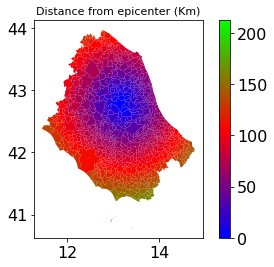

In [55]:
plt.figure(figsize = (20, 4))
mapx.plot(column='Distance_from_epicenter', cmap = 'brg', legend= True)
#plt.ylim(41.8,44)
#plt.xlim(11.3,14.8)
plt.title('Distance from epicenter (Km)',fontsize=11)
plt.show()